In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as sp_int
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Set up the constants
C_m  = 1 # membrane capacitance (uF/cm^2)
g_Na = 120 # maximum conductances (mS/cm^2)
g_K  = 36
g_l  = 0.3
E_Na = 50 # reversal potentials (mV)
E_K  = -77
E_l  = -55

In [3]:
# equations governing opening/closing rates.
def tau_m(V): return -1/(0.1*(V+40)/(1-np.exp(-(V+40)/10))+4*np.exp(-(V+65)/18))
def m_inf(V): return -(0.1*(V+40)/(1-np.exp(-(V+40)/10)))*tau_m(V)
def tau_n(V): return -1/(0.01*(V+55)/(1-np.exp(-(V+55)/10))+0.125*np.exp(-(V+65)/80))
def n_inf(V): return -(0.01*(V+55)/(1-np.exp(-(V+55)/10)))*tau_n(V)
def tau_h(V): return -1/(0.07*np.exp(-(V+65)/20)+(1/(1+np.exp(-(V+35)/10))))
def h_inf(V): return -0.07*np.exp(-(V+65)/20)*tau_h(V)

# define the currents in the model
def I_Na(V, m, h): return g_Na * (m**3)* h * (V - E_Na)
def I_K(V, n): return g_K * (n**4) * (V - E_K)
def I_l(V): return g_l * (V - E_l)

In [4]:
# define function that will return time derivatives for integration
def f(t, y):
    # set external current: make sure it is 0 for large times.
    if t <= 1:
        I_e = 50
    else:
        I_e = 0
    # set the variables that are to be integrated
    V, n, m, h = y
    # define DV/dt ('_dot' denotes time differentiation)
    V_dot = 1/C_m * (I_e - (I_K(V, n) + I_Na(V, m, h) + I_l(V)))
    # enter the equations controlling the gating variables.
    n_dot = (n - n_inf(V)) / tau_n(V)
    m_dot = (m - m_inf(V)) / tau_m(V)
    h_dot = (h - h_inf(V)) / tau_h(V)
    return [V_dot, n_dot, m_dot, h_dot]

In [5]:
# enter intial values for V, n, m, h
V_0 = -65
n_0 = 0.317
m_0 = 0.052
h_0 = 0.596
y_0 = [V_0, n_0, m_0, h_0]

In [6]:
# create timescale. t_interval is the time interval in which to calculate the solution.
# t_points are the points at which the solution is stored.
t_interval = (0.0, 40.0)
numpoints = 1000
t_points = np.linspace(t_interval[0], t_interval[1], numpoints)

In [7]:
# solve coupled ODEs with scipy's solver
soln = sp_int.solve_ivp(f, t_interval, y_0, 'RK45', t_points)

V = soln.y[0, :]
n = soln.y[1, :]
m = soln.y[2, :]
h = soln.y[3, :]

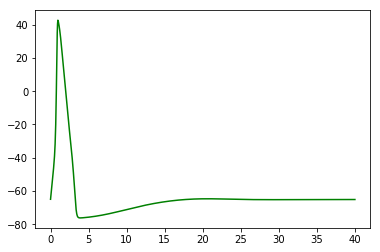

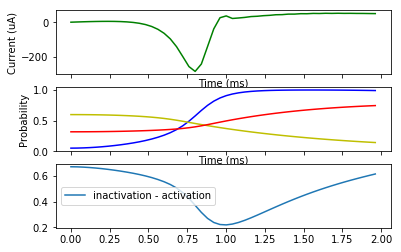

In [20]:
# plot & show solution
plt.figure(1)
plt.plot(soln.t, V, 'g') # a V, t plot
f, (ax1, ax2, ax3) = plt.subplots(3, sharex = True)
# plt.plot(soln.t, [I_Na(i, j, k) for i,j,k in zip(V, m, h)], 'blue', label='sodium current')
# plt.plot(soln.t, [I_K(i, j) for i,j in zip(V, n)], 'red', label='potassium current')
# plt.plot(soln.t, [I_l(i) for i in V], 'green', label='leak current')
t_i = 0
t_f = 50
ax1.plot(soln.t[t_i:t_f], [I_Na(i,j,k) + I_K(i,l) + I_l(i) for i,j,k,l in zip(V[t_i:t_f],m[t_i:t_f],h[t_i:t_f],n[t_i:t_f])], 'g', label='Ion currents')
ax1.set_ylabel('Current (uA)')
ax1.set_xlabel('Time (ms)')
ax2.plot(soln.t[t_i:t_f], m[t_i:t_f], 'b', label='m')
ax2.plot(soln.t[t_i:t_f], h[t_i:t_f], 'y', label='h')
ax2.plot(soln.t[t_i:t_f], n[t_i:t_f], 'r', label='n')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Time (ms)')
ax3.plot(soln.t[t_i:t_f], [-m_i + ((1 - h_i) + n_i) for m_i, h_i, n_i in zip(m[t_i:t_f], h[t_i:t_f], n[t_i:t_f])], label = 'inactivation - activation')
plt.legend()
plt.show()